# <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:150%; text-align:center; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 35px 35px;">Titanic. Survived model.</p>

<img src='https://askeyphysics.files.wordpress.com/2018/05/fullsizeoutput_50fc.jpeg' width="500" height="350">

## <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:150%; text-align:center; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 25px 5px;">Table of Contents</p>

[1. Loading and reading data](#1.-Loading-and-reading-data)  
[2. EDA](#2.-EDA)  
[3. Datasets creation](#3.-Datasets-creation)  
[4. Selection of hyperparameters](#4.-Selection-of-hyperparameters)  
* [4.1. Catboost](#4.1.-Catboost)  
* [4.2. LGBM](#4.2.-LGBM)  
* [4.3. RandomForest](#4.3.-RandomForest) 
* [4.4. Ensemble](#4.4.-Ensemble)   

[5. Best Model Submission](#5.-Best-Model-Submission)

## <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:150%; text-align:center; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 25px 5px;">1. Loading and reading data</p>

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
!pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.4/276.4 kB 506.8 kB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import phik
from phik.report import plot_correlation_matrix
from phik import report
from feature_engine.encoding import WoEEncoder

from sklearn.base import clone
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, r2_score, accuracy_score, precision_score,roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ShuffleSplit
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)

import warnings
warnings.filterwarnings('ignore')

random_state = 202301
palitra = dict(blue='#1d7990', indigo='#032733', bardo='#641216')

In [4]:
# функции
# функция для изучения данных
def def_info(df):
    print('Размер таблицы:', df.shape)
    print('____________________________________')
    print()
    print('Общая информация')
    print(df.info())
    print('____________________________________')
    print()
    print('Вывод 5и первых строк')
    display(df.head())
    print('____________________________________')
    print()
    print('Доля пропусков в таблице:')
    print(df.isna().mean())
    print('____________________________________')
    print()
    print('Доля явных дублей в данных:', df.duplicated().mean())
    print('____________________________________')
    print() 
    print('Информация по полям')
    display(df.describe(include='object').T)
    display(df.describe().T)

# функция для изучения выбросов и аномалий в данных
def boxplot_make(df, column):
    _, [axs_hist, axs_box] = plt.subplots(2, 1, figsize=(10, 4), 
                                         sharex=True,
                                         gridspec_kw=dict(height_ratios=[4,.8]))
    hist = sns.histplot(data=df, x=column, kde=True, ax=axs_hist, color=palitra['indigo'])
    box = sns.boxplot(data=df, x=column, orient='h', ax=axs_box, color=palitra['blue'])
    hist.set(title='Гистограмма распределения',
             ylabel='Количество записей');
    
# функция для изучения распределения данных по целевому признаку
def result_table(data, column, target):
    table = (data.groupby(column)[target].agg(['sum', 'count'])
    .assign(share = lambda x: x['sum'] / x['count'])
    ).sort_values(by='share', ascending=False).style.background_gradient(low=0.1, cmap='YlOrBr')
    return table

def roc_curve_make(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, linestyle='-', color=palitra['blue'])
    plt.plot([0, 1], [0, 1], linestyle='--', color=palitra['bardo'])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()
    print("ROC-AUC:", roc_auc_score(y_true, y_pred))
    
def make_plot_distribution(df, col, target):
    fig = px.histogram(train, x=col, color=target,
                       marginal='box',opacity=0.8,nbins=100,
                       barmode='group',histfunc='count', color_discrete_sequence=[palitra['blue'], palitra['bardo']])

    fig.update_layout(font_family='Arial',
                      title=dict(text=f'Distribution of {col} according to {target} variable',x=0.53,y=0.95),
                      xaxis_title_text=col,
                      yaxis_title_text='Count',
                      bargap=0.3)
    fig.show()

In [5]:
# загрузка данных
train = pd.read_csv('/kaggle/input/titanic/train.csv', index_col='PassengerId')
test = pd.read_csv('/kaggle/input/titanic/test.csv', index_col='PassengerId')
submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

In [6]:
def_info(train)

Размер таблицы: (891, 11)
____________________________________

Общая информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None
____________________________________

Вывод 5и первых строк


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


____________________________________

Доля пропусков в таблице:
Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
dtype: float64
____________________________________

Доля явных дублей в данных: 0.0
____________________________________

Информация по полям


,count,unique,top,freq
Name,891,891,"Braund, Mr. Owen Harris",1
Sex,891,2,male,577
Ticket,891,681,347082,7
Cabin,204,147,B96 B98,4
Embarked,889,3,S,644


,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [7]:
def_info(test)

Размер таблицы: (418, 10)
____________________________________

Общая информация
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Name      418 non-null    object 
 2   Sex       418 non-null    object 
 3   Age       332 non-null    float64
 4   SibSp     418 non-null    int64  
 5   Parch     418 non-null    int64  
 6   Ticket    418 non-null    object 
 7   Fare      417 non-null    float64
 8   Cabin     91 non-null     object 
 9   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB
None
____________________________________

Вывод 5и первых строк


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


____________________________________

Доля пропусков в таблице:
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age         0.205742
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.002392
Cabin       0.782297
Embarked    0.000000
dtype: float64
____________________________________

Доля явных дублей в данных: 0.0
____________________________________

Информация по полям


,count,unique,top,freq
Name,418,418,"Kelly, Mr. James",1
Sex,418,2,male,266
Ticket,418,363,PC 17608,5
Cabin,91,76,B57 B59 B63 B66,3
Embarked,418,3,S,270


,count,mean,std,min,25%,50%,75%,max
Pclass,418.0,2.265550,0.841838,1.00,1.0000,3.0000,3.0,3.0000
Age,332.0,30.272590,14.181209,0.17,21.0000,27.0000,39.0,76.0000
SibSp,418.0,0.447368,0.896760,0.00,0.0000,0.0000,1.0,8.0000
Parch,418.0,0.392344,0.981429,0.00,0.0000,0.0000,0.0,9.0000
Fare,417.0,35.627188,55.907576,0.00,7.8958,14.4542,31.5,512.3292


In [8]:
# приведем названия столбцов к нижнему регистру
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

## <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:150%; text-align:center; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 25px 5px;">2. EDA</p>

Попробуем описать потрет выжившего в трагедии с Титаником.

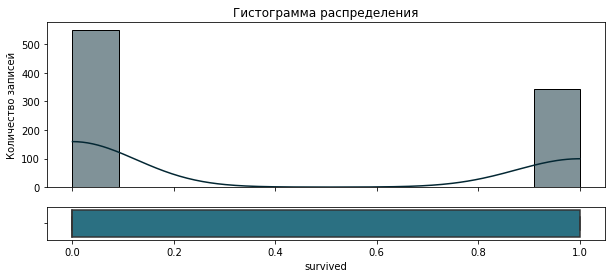

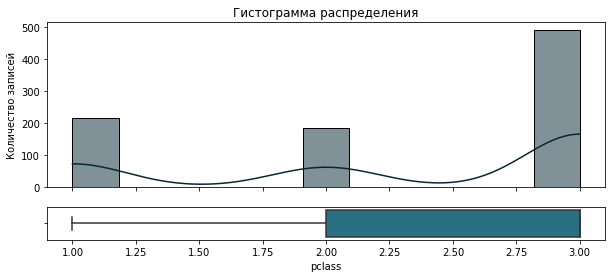

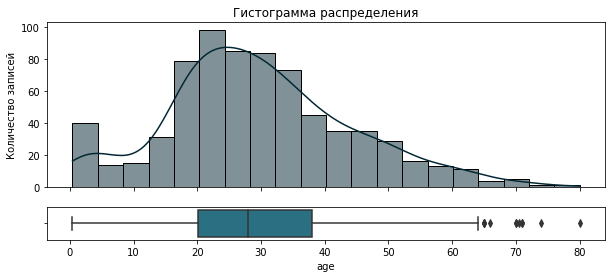

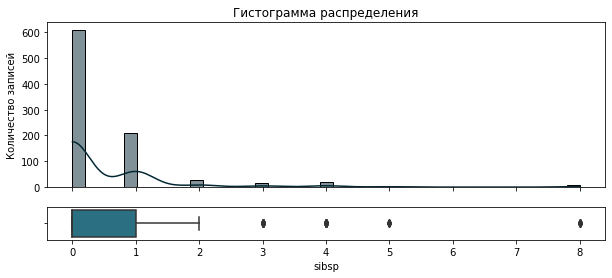

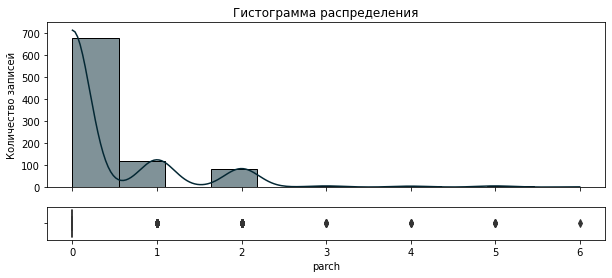

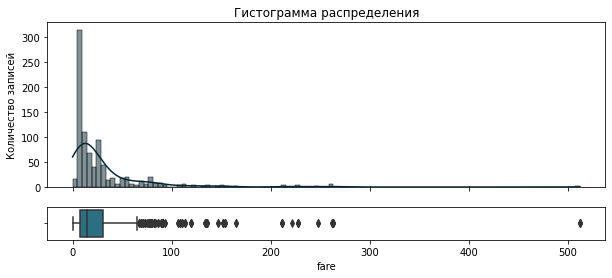

In [9]:
# цикл для посьроения графиков по всем полям цифровым
for col in train.select_dtypes(include='number').columns:
    boxplot_make(train, col)

In [10]:
col = ['pclass', 'sex', 'sibsp', 'parch', 'embarked']
for c in col:
    display(result_table(train, c, 'survived'))

,sum,count,share
pclass,,,
1,136,216,0.629630
2,87,184,0.472826
3,119,491,0.242363


,sum,count,share
sex,,,
female,233,314,0.742038
male,109,577,0.188908


,sum,count,share
sibsp,,,
1,112,209,0.535885
2,13,28,0.464286
0,210,608,0.345395
3,4,16,0.250000
4,3,18,0.166667
5,0,5,0.000000
8,0,7,0.000000


,sum,count,share
parch,,,
3,3,5,0.600000
1,65,118,0.550847
2,40,80,0.500000
0,233,678,0.343658
5,1,5,0.200000
4,0,4,0.000000
6,0,1,0.000000


,sum,count,share
embarked,,,
C,93,168,0.553571
Q,30,77,0.389610
S,217,644,0.336957


In [11]:
# функция для перевода поля в бинарное значение
train['cabin'] = train['cabin'].fillna('NNN')
test['cabin'] = test['cabin'].fillna('NNN')
def cabin_make(row):
    cabin = row['cabin']
    if cabin == 'NNN':
        return 0
    else:
        return 1
# прмиеним функцию    
train['cabin'] = train.apply(cabin_make, axis=1) 
test['cabin'] = test.apply(cabin_make, axis=1) 

In [12]:
result_table(train, 'cabin', 'survived')

,sum,count,share
cabin,,,
1,136,204,0.666667
0,206,687,0.299854


In [13]:
train.corr().style.background_gradient(low=0.1, cmap='YlOrBr')

,survived,pclass,age,sibsp,parch,fare,cabin
survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,0.316912
pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,-0.725541
age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.249732
sibsp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.040460
parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,0.036987
fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,0.482075
cabin,0.316912,-0.725541,0.249732,-0.040460,0.036987,0.482075,1.000000


In [14]:
train.phik_matrix(interval_cols=['age', 'fare']).round(2).style.background_gradient(low=0.1, cmap='YlOrBr')

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
survived,1.000000,0.210000,1.000000,0.750000,0.200000,0.180000,0.150000,0.770000,0.270000,0.470000,0.100000
pclass,0.210000,1.000000,1.000000,0.080000,0.410000,0.220000,0.030000,1.000000,0.590000,0.530000,0.580000
name,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
sex,0.750000,0.080000,1.000000,1.000000,0.130000,0.190000,0.230000,0.000000,0.180000,0.210000,0.070000
age,0.200000,0.410000,1.000000,0.130000,1.000000,0.410000,0.410000,0.800000,0.170000,0.340000,0.110000
sibsp,0.180000,0.220000,1.000000,0.190000,0.410000,1.000000,0.590000,0.870000,0.500000,0.130000,0.140000
parch,0.150000,0.030000,1.000000,0.230000,0.410000,0.590000,1.000000,0.000000,0.340000,0.090000,0.080000
ticket,0.770000,1.000000,1.000000,0.000000,0.800000,0.870000,0.000000,1.000000,1.000000,0.980000,1.000000
fare,0.270000,0.590000,1.000000,0.180000,0.170000,0.500000,0.340000,1.000000,1.000000,0.540000,0.280000
cabin,0.470000,0.530000,1.000000,0.210000,0.340000,0.130000,0.090000,0.980000,0.540000,1.000000,0.140000


## <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:150%; text-align:center; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 25px 5px;">3. Datasets creation</p>

In [15]:
# функция для замены пропусков в возрасте
def age_fillna(row):
    sex = row['sex']
    pcclass = row['pclass']
    if sex == 'female':
        if pcclass == 1:
            return 34.611765
        elif pcclass == 2:
            return 28.722973
        else:
            return 21.75
            
    elif sex == 'male':
        if pcclass == 1:
            return 41.281386
        elif pcclass == 2:
            return 30.740707
        else:
            return 26.507589

In [16]:
train['embarked'] = train['embarked'].fillna('S')
train['age'] = train['age'].fillna(train.apply(age_fillna, axis=1))

In [17]:
# функция для подготовки сетов
def make_df(table, chek):
    df = table.copy()
# заменим пропуски
    df['embarked'] = df['embarked'].fillna('N')
    df['age'] = df['age'].fillna(df.apply(age_fillna, axis=1))
# сменим тип данных
    for c in df.select_dtypes(include=['object', 'category']).columns:
        df[c] = df[c].astype('category')  
        
    if chek == 0:
        y_df = df[['survived']]
        X_df = df.drop(['name', 'ticket', 'survived'], axis=1)
        return X_df, y_df
    else:
        X_df = df.drop(['name', 'ticket'], axis=1)
        return X_df

In [18]:
X_df, y_df = make_df(train, 0)
X_test = make_df(test, 1)

In [19]:
X_test.loc[X_test['fare'].isna(), 'fare'] = X_test.query('pclass == 3 and embarked == "S"')['fare'].mean()

In [20]:
def make_woe_encoder(X):
    woe_encoder = WoEEncoder(variables=cat_features) 
    woe_encoder.fit(X_df, y_df)
    X = woe_encoder.transform(X)
    return X
def make_my_pipline(df):
    new_df = make_woe_encoder(df.copy())
    new_df[numeric_features] = StandardScaler().fit(new_df[numeric_features]).transform(new_df[numeric_features])
    return new_df

In [21]:
numeric_features = list(X_df.select_dtypes(include='number').columns)
cat_features = list(X_df.select_dtypes(include='category').columns)
numeric_features, cat_features

(['pclass', 'age', 'sibsp', 'parch', 'fare', 'cabin'], ['sex', 'embarked'])

In [22]:
X_df_pl = make_my_pipline(X_df)
X_test_pl = make_my_pipline(X_test)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X_df_pl, y_df, test_size=0.25, random_state=random_state)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((668, 8), (668, 1), (223, 8), (223, 1))

## <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:150%; text-align:center; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 25px 5px;">4. Selection of hyperparameters</p>

In [24]:
models_results = {
            'model': [],
            'accurasy': []
        }

### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">4.1. Catboost</p>

In [25]:
# подберем гипперпарметры для модели
fit_params = dict(early_stopping_rounds = 20,
                  eval_set = [(X_train, y_train), (X_val, y_val)], 
                  verbose = False)
cbc = CatBoostClassifier(random_state=random_state
                         , auto_class_weights='Balanced')
parameters = {'depth': range(2,9,2),
              'learning_rate': [.01, .1],
              'iterations': range(50,501,50),
              'l2_leaf_reg': range(2,7,2)
             }
grid_cbc = RandomizedSearchCV(cbc, parameters, scoring='accuracy', cv=5)
grid_cbc.fit(X_train, y_train, **fit_params)
grid_cbc.best_params_

{'learning_rate': 0.01, 'l2_leaf_reg': 2, 'iterations': 450, 'depth': 6}

In [26]:
params_cbc = {'learning_rate': 0.1, 'l2_leaf_reg': 6, 'iterations': 400, 'depth': 6}

In [27]:
# best_cbc = grid_cbc.best_estimator_
best_cbc = CatBoostClassifier(random_state=random_state, auto_class_weights='Balanced', **params_cbc)
best_cbc.fit(X_train, y_train, verbose=False)

pred = best_cbc.predict(X_val)
predict = best_cbc.predict_proba(X_val)[:, 1]

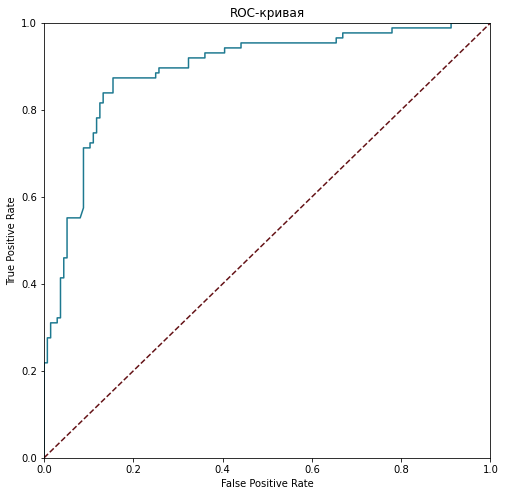

ROC-AUC: 0.8922413793103448


In [28]:
roc_curve_make(y_val, predict)

In [29]:
from catboost.utils import get_roc_curve, select_threshold

catboost_pool = Pool(X_train, y_train)
roc_curve_values = get_roc_curve(best_cbc, catboost_pool)

best_score = 0
it = 0
best_boundary = 0

for i in range(1, 100, 1):
    boundary = select_threshold(best_cbc, 
                            curve=roc_curve_values,  
                            FPR=i/100)
    predicted = (predict >= boundary)*1
    if accuracy_score(predicted, y_val) > best_score:
        best_score = accuracy_score(predicted, y_val)
        it = i
        best_boundary = boundary

best_score, it, best_boundary

(0.8565022421524664, 2, 0.5370391967468464)

In [30]:
models_results['model'].append('CatBoost')
models_results['accurasy'].append(accuracy_score((predict >= best_boundary)*1, y_val))

In [31]:
cbc = pd.DataFrame({
    'feature_name': best_cbc.feature_names_,
    'feature_score': best_cbc.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

cbc.style.background_gradient(low=0.1, cmap='YlOrBr')

,feature_name,feature_score
0,fare,26.205244
1,sex,25.364276
2,age,25.319291
3,pclass,7.056101
4,sibsp,5.428073
5,embarked,4.242596
6,cabin,3.803638
7,parch,2.580781


### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">4.2. LGBM</p>

In [32]:
# fit_params = dict(early_stopping_rounds = 20,
#                   eval_set = [(X_train, y_train), (X_val, y_val)], 
#                   verbose = 1000)
# params = {'n_estimators': range(20, 1001, 20),
#           'learning_rate': [0.005, 0.01, 0.1],
#           'max_depth': range(-1, 36, 1),
#           'num_leaves': range(1, 200, 1),
#           'boosting_type': ['gbdt', 'dart', 'goss']       
#          }
# lgbm = LGBMClassifier(random_state=random_state, class_weight='balanced')
# grid_lgbm = RandomizedSearchCV(lgbm, params, scoring='accuracy', cv=5)
# grid_lgbm.fit(X_train, y_train, **fit_params)
# grid_lgbm.best_params_

In [33]:
params_lgbm = {'num_leaves': 181, 'n_estimators': 340, 'max_depth': 8,
                         'learning_rate': 0.1, 'boosting_type': 'dart'}

In [34]:
# best_lgbm = grid_lgbm.best_estimator_
best_lgbm = LGBMClassifier(random_state=random_state, class_weight='balanced', **params_lgbm)
best_lgbm.fit(X_train, y_train)
pred = best_lgbm.predict(X_val)
predict = best_lgbm.predict_proba(X_val)[:,1]

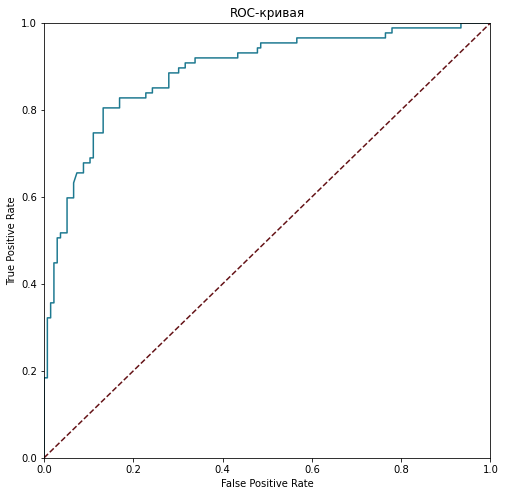

ROC-AUC: 0.888184584178499


In [35]:
roc_curve_make(y_val, predict)

In [36]:
best_score = 0
it = 0
best_boundary_lgbm = 0

for i in range(1, 100, 1):
    boundary = i/100
    predicted = (predict >= boundary)*1
    if accuracy_score(predicted, y_val) > best_score:
        best_score = accuracy_score(predicted, y_val)
        it = i
        best_boundary_lgbm = boundary

best_score, it, best_boundary_lgbm

(0.8430493273542601, 58, 0.58)

In [37]:
models_results['model'].append('LGBM')
models_results['accurasy'].append(accuracy_score((predict>=best_boundary_lgbm)*1, y_val))

In [38]:
lgb = pd.DataFrame({
    'feature_name': best_lgbm.feature_name_,
    'feature_score': best_lgbm.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

lgb.style.background_gradient(low=0.1, cmap='YlOrBr')

,feature_name,feature_score
0,fare,2812
1,age,2680
2,pclass,371
3,sibsp,333
4,sex,305
5,embarked,297
6,cabin,247
7,parch,129


### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">4.3. RandomForestClassifier</p>

In [39]:
# rfc = RandomForestClassifier(random_state=random_state, class_weight='balanced')

# params = {'n_estimators': range(100, 1001, 100),
#           'max_depth': range(1, 24, 1),
#           'min_samples_split': range(1,10,1),
#           'min_samples_leaf': range(1,10,1)
#          }

# grid_cv = RandomizedSearchCV(rfc, params, scoring='accuracy', cv=5)
# grid_cv.fit(X_train, y_train)
# grid_cv.best_params_

In [40]:
params_rfc = {'n_estimators': 900, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_depth': 9}

In [41]:
# best_rfc = grid_cv.best_estimator_
best_rfc = RandomForestClassifier(random_state=random_state, class_weight='balanced', **params_rfc)
best_rfc.fit(X_train, y_train)
pred = best_rfc.predict(X_val)
predict = best_rfc.predict_proba(X_val)[:,1]

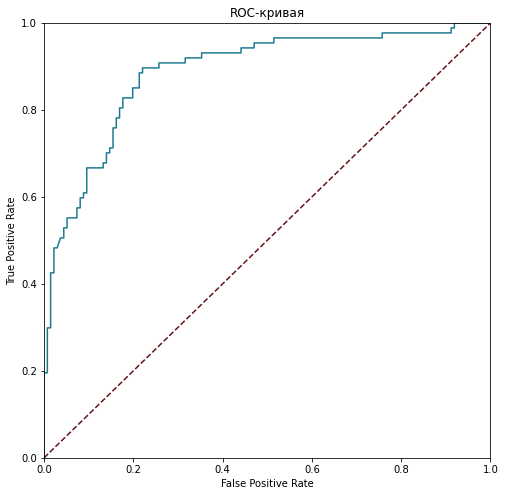

ROC-AUC: 0.886663286004057


In [42]:
roc_curve_make(y_val, predict)

In [43]:
best_score = 0
it = 0
best_boundary_rfc = 0

for i in range(1, 100, 1):
    boundary = i/100
    predicted = (predict >= boundary)*1
    if accuracy_score(predicted, y_val) > best_score:
        best_score = accuracy_score(predicted, y_val)
        it = i
        best_boundary_rfc = boundary

best_score, it, best_boundary_rfc

(0.8251121076233184, 36, 0.36)

In [44]:
models_results['model'].append('RandomForest')
models_results['accurasy'].append(accuracy_score((predict>=best_boundary_rfc)*1, y_val))

In [45]:
rfc = pd.DataFrame({
    'feature_name': best_rfc.feature_names_in_,
    'feature_score': best_rfc.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

lgb.style.background_gradient(low=0.1, cmap='YlOrBr')

,feature_name,feature_score
0,fare,2812
1,age,2680
2,pclass,371
3,sibsp,333
4,sex,305
5,embarked,297
6,cabin,247
7,parch,129


### <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:120%; text-align:left; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 5px 5px;">4.4. Ensemble</p>

In [46]:
best_cbc.fit(X_train, y_train, verbose=False)
best_lgbm.fit(X_train, y_train, verbose=False)
best_rfc.fit(X_train, y_train)
ens_pred_prob = (np.column_stack([best_cbc.predict_proba(X_val)[:,1], 
                                 best_rfc.predict_proba(X_val)[:,1],
                                 best_lgbm.predict_proba(X_val)[:,1]]
                               ).mean(axis=1) >=0.5
                )*1
models_results['model'].append('Ensemble')
models_results['accurasy'].append(accuracy_score(ens_pred_prob, y_val))

## <p style="background-color:#641216; font-family:Nexa; color:#e8f8f5; font-size:150%; text-align:center; border: 2.5px; border-style:solid; border-color:#210400; border-radius: 25px 5px;">5. Best Model Submission</p>

In [47]:
pd.DataFrame(data=models_results).sort_values('accurasy', ascending=False).style.background_gradient(low=0.1, cmap='YlOrBr')

,model,accurasy
0,CatBoost,0.856502
1,LGBM,0.843049
3,Ensemble,0.838565
2,RandomForest,0.825112


In [48]:
best_cbc.fit(X_df_pl, y_df, verbose=False)
submission['Survived'] = (best_cbc.predict_proba(X_test_pl)[:,1] >= best_boundary)*1
submission.to_csv('submission.csv', index = False)